# Local Explainable AI (XAI) Tests

This notebook implements and tests LIME and SHAP explainability methods for our top-performing models:
1. XGBoost_Tuned (Primary XAI focus, ROC-AUC ≈0.804)
2. RandomForest_Tuned (F1 ≈0.383)
3. NeuralNetwork_Tuned (Recall ≈0.815)

## Objectives
1. Implement LIME and SHAP explainers
2. Generate and visualize explanations
3. Compare explanation quality across models
4. Document clinical interpretability insights

In [20]:
# Import required libraries
import sys
import os
import numpy as np
import pandas as pd
import joblib

# Optional imports (may be heavy in some environments)
try:
    import torch
except Exception:
    torch = None

import matplotlib.pyplot as plt
import seaborn as sns

# Ensure working directory is at project root
project_root = '/Users/peter/AI_ML_Projects/health_xai_project'
os.chdir(project_root)
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print(f"Working directory set to: {os.getcwd()}")

# Import explainability helpers
from src.explainability import (
    load_models, get_predict_fn, build_lime_explainer,
    build_shap_explainers, explain_instance_lime, explain_instance_shap, save_figure,
)

# Set random seed for reproducibility
np.random.seed(42)
if torch is not None:
    torch.manual_seed(42)


Working directory set to: /Users/peter/AI_ML_Projects/health_xai_project


In [19]:
# Quick environment check: current working directory and data/processed contents
import os
import sys
import importlib

print('cwd ->', os.getcwd())
print('\n/data/processed contents:')
print(os.listdir('data/processed'))

# Force reload of explainability module to get latest changes
if 'src.explainability' in sys.modules:
    del sys.modules['src.explainability']
if 'src.models.neural_network' in sys.modules:
    del sys.modules['src.models.neural_network']
print("\nModules reloaded")


cwd -> /Users/peter/AI_ML_Projects

/data/processed contents:


FileNotFoundError: [Errno 2] No such file or directory: 'data/processed'

In [15]:
# Load data and models using src.explainability helpers
def load_models_and_data():
    # Load processed datasets
    X_train = pd.read_csv('data/processed/train.csv')
    X_test = pd.read_csv('data/processed/test.csv')
    y_train = X_train.pop('hltprhc')
    y_test = X_test.pop('hltprhc')

    # Feature names file expected to have column 'feature_name'
    # skip commented lines starting with '#'
    feature_names = pd.read_csv('data/processed/feature_names.csv', comment='#')

    # Load available models from results/models/
    models = load_models('results/models')
    scaler = models.get('scaler')
    return (X_train, X_test, y_train, y_test), models, scaler, feature_names

# Execute loading
(X_train, X_test, y_train, y_test), models, scaler, feature_names = load_models_and_data()

print("Data shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print("\nModels loaded:")
for name in models.keys():
    print(f"- {name}")
print(f"\nNumber of features: {len(feature_names)}")

Data shapes:
X_train: (29663, 51)
X_test: (6357, 51)

Models loaded:
- xgboost
- random_forest
- neural_network
- scaler

Number of features: 25


## LIME Implementation

LIME (Local Interpretable Model-agnostic Explanations) creates interpretable representations of complex models by fitting simple linear models around individual predictions. We'll implement it first as it's generally faster than SHAP and can give us quick insights.

In [10]:
# Build LIME explainer using helper
feature_list = feature_names['feature_name'].tolist() if 'feature_name' in feature_names.columns else list(X_train.columns)
lime_explainer = build_lime_explainer(X_train, feature_list)

# Build model prediction wrappers (predict_proba style)
predict_fns = {}
for key, model in models.items():
    if key == 'neural_network':
        predict_fns[key] = get_predict_fn(model, model_type='pytorch')
    elif key in ('xgboost', 'random_forest'):
        predict_fns[key] = get_predict_fn(model, model_type='sklearn')

print("LIME explainer and predict functions ready for models:", list(predict_fns.keys()))

LIME explainer and predict functions ready for models: ['xgboost', 'random_forest', 'neural_network']


Generating LIME explanation for a positive case using XGBoost (if available)
True label: Heart Condition
Predicted probability: 0.880
Feature contributions (LIME):


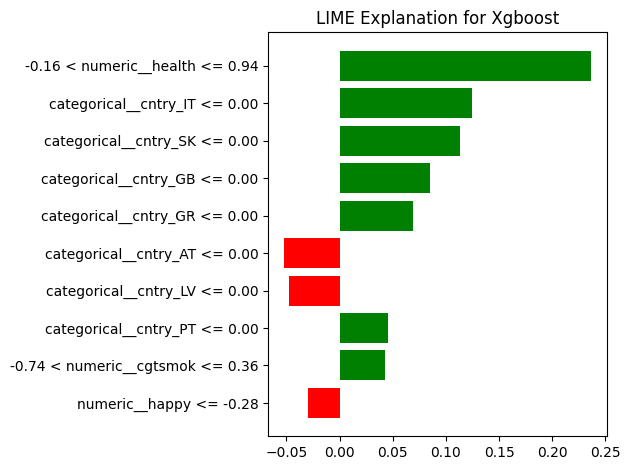

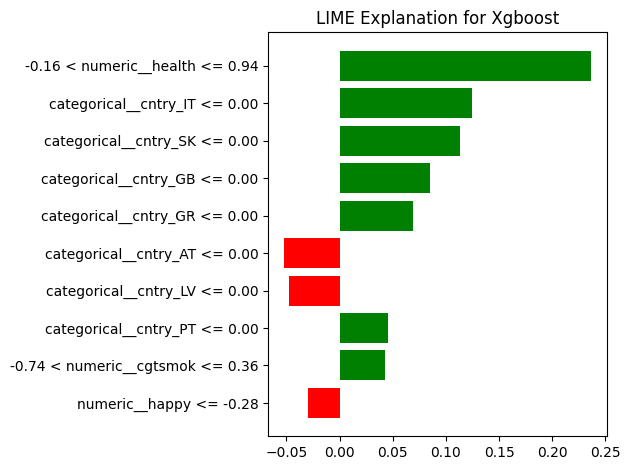

In [11]:
# Function to generate and visualize LIME explanations using helper
def explain_with_lime(instance_idx, model_name='xgboost', num_features=10):
    instance = X_test.iloc[instance_idx]
    true_label = y_test.iloc[instance_idx]
    pred_proba = predict_fns[model_name](instance.values.reshape(1, -1))[0][1]
    print(f"True label: {'Heart Condition' if true_label == 1 else 'No Heart Condition'}")
    print(f"Predicted probability: {pred_proba:.3f}")
    print('Feature contributions (LIME):')
    exp = lime_explainer.explain_instance(instance.values, predict_fns[model_name], num_features=num_features)
    fig = exp.as_pyplot_figure()
    plt.title(f"LIME Explanation for {model_name.replace('_', ' ').title()}")
    plt.tight_layout()
    return exp, fig

# Find a positive example (if available)
positive_idxs = np.where(y_test.values == 1)[0]
if len(positive_idxs) == 0:
    raise RuntimeError('No positive samples found in test set to explain.')
positive_idx = int(positive_idxs[0])
print("Generating LIME explanation for a positive case using XGBoost (if available)")
if 'xgboost' in predict_fns:
    lime_exp_xgb, lime_fig = explain_with_lime(positive_idx, 'xgboost')
    display(lime_fig)
else:
    print('XGBoost model not available for LIME explanation.')

## SHAP Implementation

Now we'll implement SHAP (SHapley Additive exPlanations) analysis. SHAP provides consistent, locally accurate feature attribution based on game theory. We'll focus on TreeExplainer for XGBoost/RandomForest and KernelExplainer for the neural network.

In [16]:
# Initialize SHAP explainers using helper (may take some time for KernelExplainer)
background = X_train.sample(min(200, len(X_train)), random_state=42)
shap_explainers = build_shap_explainers(models, background=background)
print("SHAP explainers initialized:", list(shap_explainers.keys()))

Provided model function fails when applied to the provided data set.


AttributeError: 'collections.OrderedDict' object has no attribute 'eval'

In [ ]:
# Function to generate and visualize SHAP values using helper
def explain_with_shap(instance_idx, model_name='xgboost'):
    instance = X_test.iloc[instance_idx:instance_idx+1]
    true_label = y_test.iloc[instance_idx]
    explainer = shap_explainers.get(model_name)
    if explainer is None:
        raise RuntimeError(f'No SHAP explainer available for {model_name}')
    shap_values = explain_instance_shap(explainer, instance)
    pred_proba = predict_fns[model_name](instance.values)[0][1]
    print(f"True label: {'Heart Condition' if true_label == 1 else 'No Heart Condition'}")
    print(f"Predicted probability: {pred_proba:.3f}")
    # Force plot (matplotlib)
    plt.figure(figsize=(14, 2))
    try:
        shap.force_plot(explainer.expected_value if not isinstance(explainer.expected_value, list) else explainer.expected_value[1], shap_values, instance, feature_names=feature_list, matplotlib=True, show=False)
        plt.title(f"SHAP Force Plot for {model_name.replace('_', ' ').title()}")
        plt.tight_layout()
    except Exception as e:
        print('Could not generate matplotlib force_plot:', e)
    return shap_values

# Test SHAP on the positive example if available
if 'xgboost' in shap_explainers:
    print("Generating SHAP explanation for positive case (XGBoost)...")
    shap_values_xgb = explain_with_shap(positive_idx, 'xgboost')
else:
    print('No XGBoost SHAP explainer available')

## Global Feature Importance

Let's generate global feature importance plots using SHAP values to understand overall model behavior.

In [ ]:
# Generate SHAP summary plots for each available model
def generate_global_shap_summary(model_name='xgboost', n_samples=200):
    test_sample = X_test.sample(min(n_samples, len(X_test)), random_state=42)
    expl = shap_explainers.get(model_name)
    if expl is None:
        print(f'No SHAP explainer for {model_name}')
        return
    shap_vals = expl.shap_values(test_sample)
    if isinstance(shap_vals, list):
        shap_vals = shap_vals[1]
    plt.figure(figsize=(10, 8))
    try:
        shap.summary_plot(shap_vals, test_sample, feature_names=feature_list, show=False)
        plt.title(f'SHAP Summary Plot for {model_name.replace('_', ' ').title()}')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print('Could not render SHAP summary_plot:', e)

for m in shap_explainers.keys():
    print('Generating global SHAP summary for', m)
    generate_global_shap_summary(m)

## Save Explanations

Let's save our LIME and SHAP explanations for the demo and documentation.

In [ ]:
# Create directories if they don't exist
os.makedirs('results/explanations/lime_explanations', exist_ok=True)
os.makedirs('results/explanations/shap_summary_plots', exist_ok=True)

# Save LIME and SHAP figures generated above (if present)
def save_current_explanations():
    try:
        if 'lime_exp_xgb' in globals():
            fig = lime_exp_xgb.as_pyplot_figure()
            fig.savefig('results/explanations/lime_explanations/sample_explanation_xgboost.png', bbox_inches='tight', dpi=300)
    except Exception as e:
        print('Could not save LIME figure:', e)
    try:
        for m in shap_explainers.keys():
            generate_global_shap_summary(m)
            plt.savefig(f'results/explanations/shap_summary_plots/{m}_summary.png', bbox_inches='tight', dpi=300)
            plt.close()
    except Exception as e:
        print('Could not save SHAP figures:', e)

print('Saving explanations to results/explanations/...')
save_current_explanations()
print('Explanations saved successfully!')